In [1]:

import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [2]:
count = 0
dirs = os.listdir(r'C:\Users\ROG STRIX\Documents\000000000000000 MESIN\Projek UAS PMDPM_A_Pandas\train_data')
for dir in dirs:
    files = list(os.listdir(r'C:\Users\ROG STRIX\Documents\000000000000000 MESIN\Projek UAS PMDPM_A_Pandas\train_data/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

Jeruk Lemon Folder has 100 Images
Jeruk Nipis Folder has 100 Images
Jeruk Sunkist Folder has 100 Images
Images Folder has 300 Images


In [3]:

base_dir = r'C:\Users\ROG STRIX\Documents\000000000000000 MESIN\Projek UAS PMDPM_A_Pandas\train_data' 
img_size = 180 
batch = 32 
validation_split = 0.1

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir, 
    seed=123,
    image_size=(img_size, img_size), 
    batch_size=batch,
    validation_split=validation_split,
    subset="training",
)

Found 300 files belonging to 3 classes.


Using 270 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir, 
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
    validation_split=validation_split,
    subset="validation",
)

Found 300 files belonging to 3 classes.
Using 30 files for validation.


In [6]:

class_names = dataset.class_names 
print("Class Names:", class_names)

Class Names: ['Jeruk Lemon', 'Jeruk Nipis', 'Jeruk Sunkist']


In [7]:
total_count = len(dataset)
val_count = len(val_ds)
train_count = total_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)

Total Images: 9
Train Images: 8
Validation Images: 1


In [8]:

train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

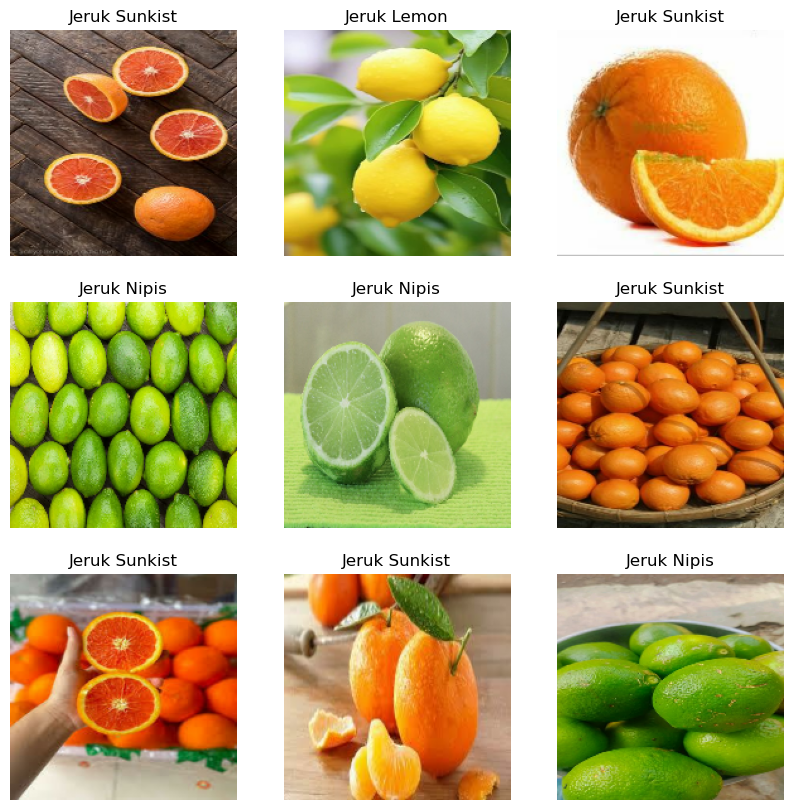

In [9]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,10)) 

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [10]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)  

(32, 180, 180, 3)


In [11]:

AUTOTUNE = tf.data.AUTOTUNE

In [12]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [13]:

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [14]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)), 
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1) 
])

d:\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


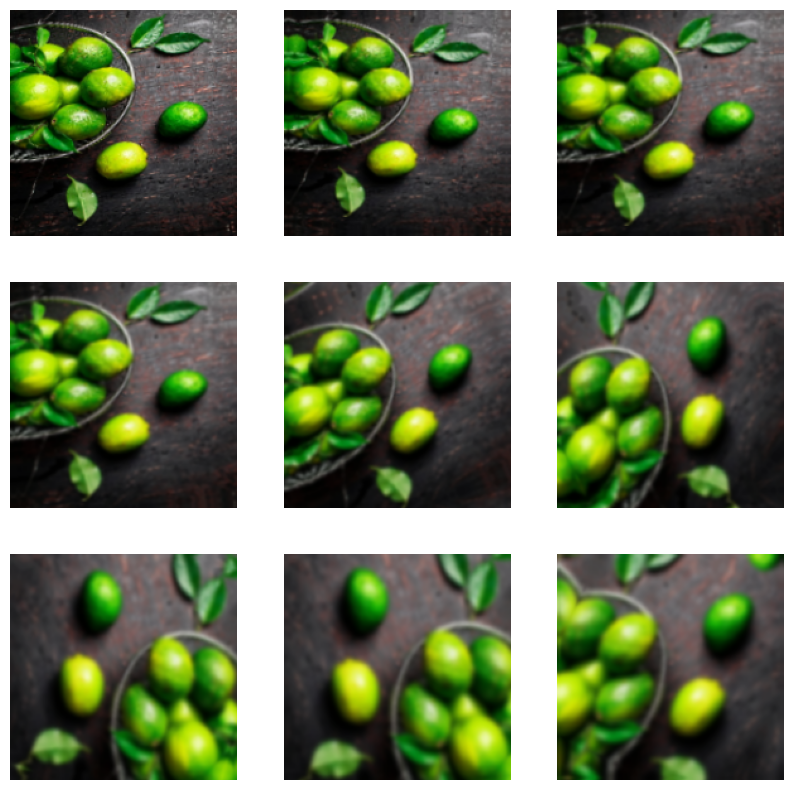

In [15]:

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [16]:

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model 

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])


d:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
from tensorflow.keras.optimizers import Adam 

model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'] 
)


In [18]:

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,363 (25.36 MB)

 Trainable params: 6,647,363 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               mode='max')


history= model.fit(train_ds, 
                   epochs=30, 
                   validation_data=val_ds, 
                   callbacks=[early_stopping])

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.3287 - loss: 1.0991 - val_accuracy: 0.7143 - val_loss: 0.9764
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.6122 - loss: 0.9569 - val_accuracy: 0.8571 - val_loss: 0.5621
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.6696 - loss: 0.8141 - val_accuracy: 1.0000 - val_loss: 0.4761
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.8408 - loss: 0.5958 - val_accuracy: 1.0000 - val_loss: 0.2419
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.8329 - loss: 0.4637 - val_accuracy: 0.8571 - val_loss: 0.2924
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.8667 - loss: 0.4076 - val_accuracy: 1.0000 - val_loss: 0.1986


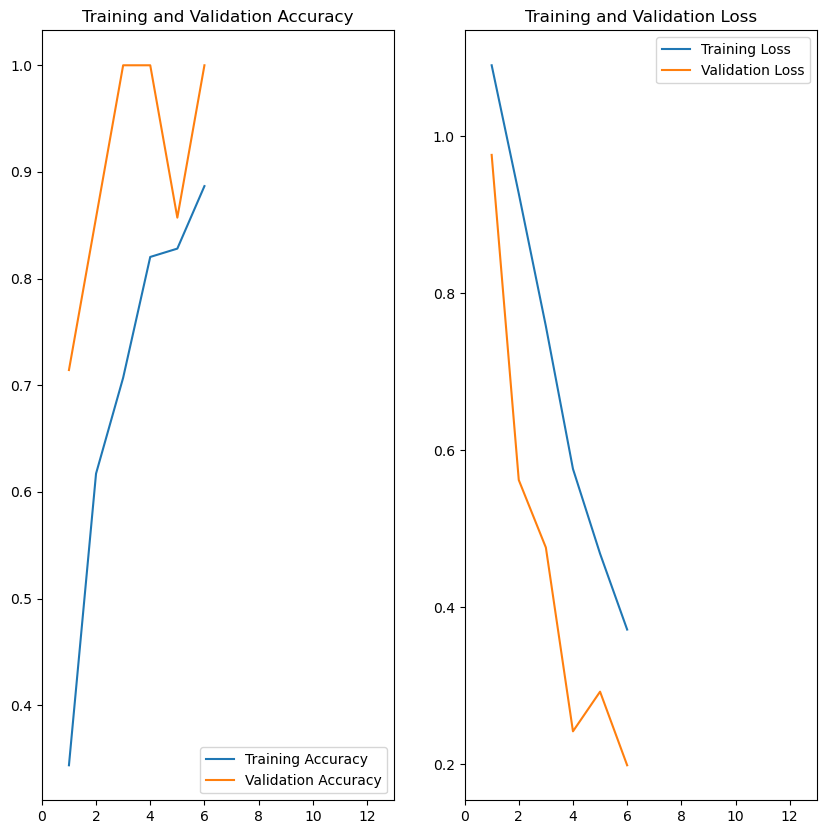

In [20]:

ephocs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10)) 
plt.subplot(1, 2, 1) 
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')  
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.xlim(0, 13)
plt.title('Training and Validation Accuracy') 

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(0, 13)
plt.title('Training and Validation Loss')
plt.show()

In [21]:

model.save('BestModel_MobileNet_Pandas.h5')

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image


model = load_model(r'C:\Users\ROG STRIX\Documents\000000000000000 MESIN\Projek UAS PMDPM_A_Pandas\BestModel_MobileNet_Pandas.h5')  
class_names = ['Jeruk Lemon', 'Jeruk Nipis', 'Jeruk Sunkist'] 

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180)) 
        input_image_array = tf.keras.utils.img_to_array(input_image) 
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  
                                                                    
        predictions = model.predict(input_image_exp_dim) 
        result = tf.nn.softmax(predictions[0]) 
        class_idx = np.argmax(result) 
        confidence = np.max(result) * 100 

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path) 
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'test_data/Jeruk Sunkist/jeruk_sunkist_test_5.jpg', save_path='sunkist.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Prediksi: Jeruk Sunkist
Confidence: 54.42%
Prediksi: Jeruk Sunkist dengan confidence 54.42%. Gambar asli disimpan di sunkist.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


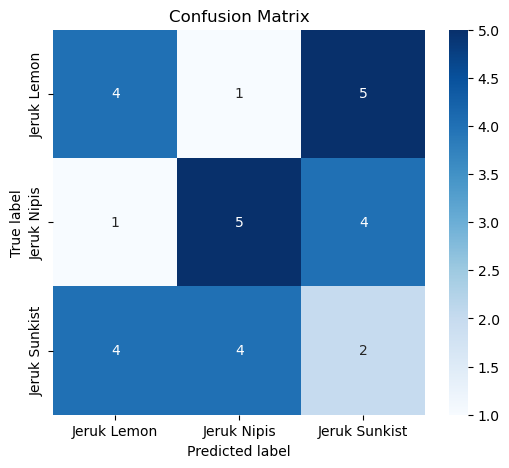

Confusion Matrix:
 [[4 1 5]
 [1 5 4]
 [4 4 2]]
Akurasi: 0.36666666666666664
Presisi: [0.44444444 0.5        0.18181818]
Recall: [0.4 0.5 0.2]
F1 Score: [0.42105263 0.5        0.19047619]


In [23]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

mobileNet_model = load_model(r'C:\Users\ROG STRIX\Documents\000000000000000 MESIN\Projek UAS PMDPM_A_Pandas\BestModel_MobileNet_Pandas.h5')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data', 
    labels='inferred', 
    label_mode='categorical',  
    batch_size=32, 
    image_size=(180, 180) 
)


y_pred = mobileNet_model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)  


true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())  
true_labels = tf.convert_to_tensor(true_labels) 

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues',
            
            xticklabels=["Jeruk Lemon", "Jeruk Nipis", "Jeruk Sunkist"], yticklabels=["Jeruk Lemon", "Jeruk Nipis", "Jeruk Sunkist"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())
